# Actividad

En esta actividad vas a trabajar con el clasificador que está en el _notebook_ junto a esta actividad. Aquí debes usar esta clase para crear un clasificador de _spam_. En concreto se te pide lo siguiente:

1. **(2.5 pts)** Crea un clasificador Naive Bayes que se entrene con los asuntos (_Subject_) del _dataset_ de correos que te presentamos. Separa el _dataset_ de tres formas: (1) 0.5 de entrenamiento y prueba; (2) 0.7 de entrenamiento y 0.3 de prueba; (3) 0.3 de entrenamiento y 0.7 de prueba. ¿Cómo se comporta el clasificador en cada uno de estos escenarios? ¿Qué puedes concluir respecto al _ratio_ entrenamiento / prueba? Para cada uno de los casos presenta la matriz de confusión.

2. **(2.5 pts)** En esta parte tienes que experimentar con la precisión y el _recall_, para esto:
  - **(1 pto)** Identifica cuál es el threshold en este caso. ¿Cómo puedes hacer un modelo más preciso? ¿Cómo puedes hacer un modelo con más _recall_? Discute cómo cambiarías el código para lograr ambas cosas.
  - **(1.5 pts)** Prueba la precisión y el _recall_ para distintos valores del threshold y discute los resultados. Grafica la curva de precisión y _recall_ vs el threshold.
  
3. **(1 pto)** Supón que ahora en vez de clasificar _spam_ y _no spam_ quieres hacer un modelo que lo clasifique para distintas etiquetas. Por ejemplo, imagina que tienes una etiqueta para cada uno de tus cursos, y quieres clasificar los correos a algunas de esas etiquetas. ¿Cómo puedes extender el modelo para que sea multiclase? No es necesario mostrar código, solamente que lo expliques con tus propias palabras.

4. **(0.5 pts) \[BONUS\]** Grafica la curva ROC del modelo para tu set de prueba. Discute los resultados.

## Detalles académicos

Este control pueden realizarlo en grupos de hasta dos personas. La entrega de este control debe ser un archivo comprimido donde se encuentre un **Jupyter Notebook**, junto a cualquier archivo .csv que estés llamando desde tu código. **La fecha de entrega es hasta jueves 17 de septiembre, hasta las 20:00 pm, cualquier entrega después de este plazo será calificada con la nota mínima**. La nota se calcula como el número de puntos + un punto base. El archivo comprimido se entrega en un cuestionario de Webcursos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# PARTE 0
Utilizamos todo lo que aparece en Naive bayes para poder crear el clasificador de mails.
 

In [ ]:
import re
from collections import defaultdict # Diccionario con valores default
import math
import random
from google.colab import drive
import glob, re
drive.mount('/content/drive')

def tokenize(text):
    text = text.lower()                         # Pasar a minúsculas
    all_words = re.findall("[a-z0-9']+", text)  # Extraer las palabras con expresiones regulares
    return set(all_words)                       # Con un Set no tenemos duplicados

class Mail():
    def __init__(self, content, is_spam):
        self.content = content
        self.is_spam = is_spam

class NaiveBayesClassifier:
    def __init__(self, k=0.5):
        self.k = k  # smoothing factor

        self.tokens = set()
        self.token_spam_counts = defaultdict(int)
        self.token_ham_counts = defaultdict(int)
        self.spam_messages = 0
        self.ham_messages = 0

    # Función para entrenar
    def train(self, messages):
        for message in messages:
            # Increment message counts
            if message.is_spam:
                self.spam_messages += 1
            else:
                self.ham_messages += 1

            # Increment word counts
            for token in tokenize(message.content):
                self.tokens.add(token)
                if message.is_spam:
                    self.token_spam_counts[token] += 1
                else:
                    self.token_ham_counts[token] += 1

    # Función que calcula las probabilidades asociadas a cada palabra
    # Si la palabra no está usaremos (1 - la probabilidad)
    def probabilities(self, token):
        # Retorna P(token | spam) y P(token | not spam)
        spam = self.token_spam_counts[token]
        ham = self.token_ham_counts[token]

        p_token_spam = (spam + self.k) / (self.spam_messages + 2 * self.k)
        p_token_ham = (ham + self.k) / (self.ham_messages + 2 * self.k)

        return p_token_spam, p_token_ham

    # Función para predecir un texto
    def predict(self, text):
        text_tokens = tokenize(text)
        log_prob_if_spam = 0.0
        log_prob_if_ham = 0.0

        # Vemos todo nuestro vocabulario
        for token in self.tokens:
            prob_if_spam, prob_if_ham = self.probabilities(token)

            # Si el token aparece en el mensaje sumamos el log de la probabilidad asociada
            if token in text_tokens:
                log_prob_if_spam += math.log(prob_if_spam)
                log_prob_if_ham += math.log(prob_if_ham)

            # En otro caso, sumamos el log de la probabilidad de no haberlo visto: log(1 - probabilidad de ver el mensaje)
            else:
                log_prob_if_spam += math.log(1.0 - prob_if_spam)
                log_prob_if_ham += math.log(1.0 - prob_if_ham)

        prob_if_spam = math.exp(log_prob_if_spam)
        prob_if_ham = math.exp(log_prob_if_ham)
        return prob_if_spam / (prob_if_spam + prob_if_ham)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np

def split_data(data, perc):
    data = data[:]                    # Copiamos el dataset
    random.shuffle(data)              # porque shuffle modifica la lista, aquí la ordenamos de forma aleatoria
    cut = int(len(data) * perc)       # Vemos hasta que posición tomamos
    return data[:cut], data[cut:]     # Retornamos las dos partes

PATH_MAILS = '/content/drive/My Drive/Colab Notebooks/mails/*/*'

data = []

# Recorremos todos los archivos
for filename in glob.glob(PATH_MAILS):
    # Checkeamos si es spam o no
    is_spam = 'ham' not in filename
    
    # Ignoramos los posibles errores al abrir un archivo
    with open(filename, errors='ignore') as mail_file:
       for line in mail_file:
            if line.startswith("Subject:"):
                # Hacemos strip desde la izquierda
                subject = line.lstrip("Subject: ")
                data.append(Mail(subject, is_spam))
                # Después de añadir el subject terminamos
                break

# Parte 1
Con todo lo anterior ya ejecutado nos enfocamos en crear los tres modelos distintos con las distintas distribuciones. A su vez, para probar el clasificador crearemos un mensaje el cual se acople de manera correcta a los mails que recibia.

In [ ]:
train_mails1, test_mails1 = split_data(data, 0.7)
train_mails2, test_mails2 = split_data(data, 0.5)
train_mails3, test_mails3 = split_data(data, 0.3)
#los tres modelos (0,7 y 0,3 | 0,5 y 0,5 | 0,3 y 0,7)
model1 = NaiveBayesClassifier(k=0.5)
model2 = NaiveBayesClassifier(k=0.5)
model3 = NaiveBayesClassifier(k=0.5)
#Todos los modelos con el mismo k, basandonos en lo visto en la clase
model1.train(train_mails1)
model2.train(train_mails2)
model3.train(train_mails3)
#Si se ofende por el mensaje, no sabe lo que es Spam
mail=(Mail("Make your penis bigger in one click !!!",is_spam=True))
#corroboramos que tan cerca están de ser spam
print("Modelo 0,7 entrenamiento y 0,3 prueba: ", model1.predict(mail.content))
print("Modelo 0,5 entrenamiento y 0,5 prueba: ", model2.predict(mail.content))
print("Modelo 0,3 entrenamiento y 0,7 prueba: ", model3.predict(mail.content))

Modelo 0,7 entrenamiento y 0,3 prueba:  0.9575196255445793
Modelo 0,5 entrenamiento y 0,5 prueba:  0.5683483334154003
Modelo 0,3 entrenamiento y 0,7 prueba:  0.9686157627638751


Estos numeros nos hacen ver que los modelos predicen de buena forma y a medida que se disminuye el grupo de entrenamiento baja la precision del modelo, por lo mismo pasaremos a mostrar las matrices de confusión.

In [ ]:
from sklearn.metrics import confusion_matrix
Modelo_1=[]
Modelo_2=[]
Modelo_3=[]
Real_1 =[]
Real_2 =[]
Real_3 =[]
for mail in test_mails1:
  if model1.predict(mail.content) >=0.5:
    Modelo_1.append(1)
  else:
    Modelo_1.append(0)
  if mail.is_spam == True:
    Real_1.append(1)
  else:
    Real_1.append(0)

for mail in test_mails2:
  if model2.predict(mail.content) >=0.5:
    Modelo_2.append(1)
  else:
    Modelo_2.append(0)
  if mail.is_spam == True:
    Real_2.append(1)
  else:
    Real_2.append(0)

for mail in test_mails3:
  if model3.predict(mail.content) >=0.5:
    Modelo_3.append(1)
  else:
    Modelo_3.append(0)
  if mail.is_spam == True:
    Real_3.append(1)
  else:
    Real_3.append(0)

print("Modelo 0,7 entrenamiento y 0,3 prueba: ", confusion_matrix(Real_1, Modelo_1))
print("Modelo 0,5 entrenamiento y 0,5 prueba: ", confusion_matrix(Real_2, Modelo_2))
print("Modelo 0,3 entrenamiento y 0,7 prueba: ", confusion_matrix(Real_3, Modelo_3))

Modelo 0,7 entrenamiento y 0,3 prueba:  [[811  26]
 [ 51 102]]
Modelo 0,5 entrenamiento y 0,5 prueba:  [[1378   37]
 [ 104  131]]
Modelo 0,3 entrenamiento y 0,7 prueba:  [[1935   30]
 [ 192  153]]


La misma Matriz de confusión nos muestran como van evolucionando los modelos, funcionando de buena manera en cada uno de ellos, pero aumentando de a poco los valores erroneos (falsos positivos y falsos positivos)
## PARTE 2
Primero que todo, sabemos que el threshold es 0,5, debido a que este valor es el que define si un mail es spam o no. Para poder hacer que el modelo tenga una mayor precision, debemos enfocarnos en que se disminuyan al maximo los Falsos Positivos, lo cual se puede hacer alterando el Threshold. Mientras, para aumentar el recall debemos disminuir los Falsos negativos, lo que se puede conseguir modificando el Threshold en el sentido contrario que para precision. 

Por lo mismo, en vez de ir alterando los valores del Threshold y ver los resultados creamos una script que nos mostrara en que puntos se puede conseguir la maxima precision, el maximo recall y el punto de intercepcion de ambos.

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics import confusion_matrix
#Al ser el modelo que mejor funcionó lo utilizaremos para esta prueba
train_mails, test_mails = split_data(data, 0.7)

model = NaiveBayesClassifier(k=0.5)

model.train(train_mails)
Modelo= []
Real = []
for mail in test_mails:
  Modelo += [model.predict(mail.content)]
  Real += [mail.is_spam]

#threshold = widgets.FloatSlider(min=0.000,max=1.000, step=0.0001)
#display(threshold)

Crearemos una función para descubrir en que puntos de Threshold la presicion, el recall estan en sus puntos maximos, ademas de la intercepcion de ellos dos.


In [ ]:
#Utilizando F1 Score llegamos al punto de intercepcion
#Variables que entregaran la posición del 
posicion1=0
posicion2=0
posicion3=0
posicion4=0
#P significa Precision y R Recall
p1=0
r1=0
for i in range(1, 10000):
  Resultado = []
  for dato in Modelo:
    Resultado += [dato > i/10000]
  confusion_matrix_p2 = confusion_matrix(Real, Resultado)
  #Conociendo la matriz de confusión podemos llamar a los valores especificos y conseguir las distintas medidas
  presicion = confusion_matrix_p2[0][0] / (confusion_matrix_p2[0][0] + confusion_matrix_p2[0][1])
  recall = confusion_matrix_p2[0][0] / (confusion_matrix_p2[0][0] + confusion_matrix_p2[1][0])
  F1= 2*(presicion*recall)/(presicion+recall)
  #Guardar el mayor valor en los distintos casos
  if valor < F1:
    valor=F1
    posicion1=i
  if p1<presicion:
    p1=presicion
    posicion2=i
  if r1<recall:
    r1=recall
    posicion3=i
  if presicion == recall:
    posicion4=i
    
print("Valor F1 :",posicion1/10000)
print("Threshold intercepción:",posicion4/10000 )
print("Presicion:",posicion2/10000)
print("Recall:",posicion3/10000)

Valor F1 : 0.7558
Threshold intercepción: 0.2151
Presicion: 0.9988
Recall: 0.0021


Teniendo claridad de los valores encontrados podemos darnos cuenta que la Precision como el Recall tienen sus valores maximos en los extremos opuestos del Threshold, siendo la precision maxima cuando el Threshold se encuentra muy cerca de 1 y el Recall maximo lo más cercano a 0 que pueda ser.
Este comportamiento nos deja en claro como funcionan estas medidas, las cuales no siempre nos entregan el resultado que sea mejor para la evaluacion del modelo. Por eso utilizamos F1 Score para encontrar el punto de intercepción en donde el modelo sea el mejor en ambos sentidos.

In [ ]:
ModeloF1=[]
RealF1=[]
for mail in test_mails:
  if model.predict(mail.content) >=0.2151:
    ModeloF1.append(1)
  else:
    ModeloF1.append(0)
  if mail.is_spam == True:
    RealF1.append(1)
  else:
    RealF1.append(0)
print(confusion_matrix(RealF1, ModeloF1))

NameError: ignored

Ya teniendo claro esto nos basaremos en lo pasado en clases, en la parte de clasificación, para graficar y ver como nuestro resultado de F1 Score coincide con el grafico, el cual deberia mostrar el valor del Threshold 0,2151 y un punto de equilibrio de 0,7558

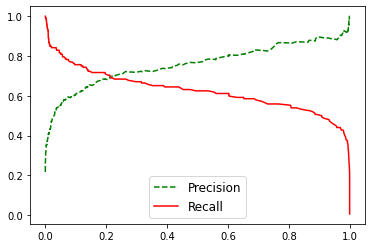

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'g--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'r-', label='Recall')
    plt.legend(loc="lower center", fontsize=12)

precisions, recalls, thresholds = precision_recall_curve(Real, Modelo)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

# PARTE 3
Para poder hacer un clasificador multiclases podemos tener muchas opciones. Desde utilizar la estrategia "One-versus-the-Rest" la cual implica en utilizar el modelo para cada uno de las distintas clases que se quieran clasificar, hasta la opcion de modificar los intervalos de Threshold. Creo que la opción más segura para tener distintas clasificaciones es utilizar el One-versus-the Rest, mientras sean pocas las clases que se intenten generar. La opcion de utilizar distintos intervalos para generar multiples clases tambien suena rentable, aunque seria una medida restrictiva, ya que solo se podria pertenecer a una clase dependiendo del intervalo en el que se encuentra.
Teniendo claridad de esto podemos concluir quye la opcion de tener un clasificadoer multivariable basandonos en el modelo Naives Bayes es posible, pero no podemos asegurar que sea un buen modelo. En caso de que se requiera tener una claridad absoluta de las clases, se recomienta un modelo multiclase previamente definido.

# PARTE 4
Utilizaremos los scripts que mostraron en clases para graficar la Curva ROC. 


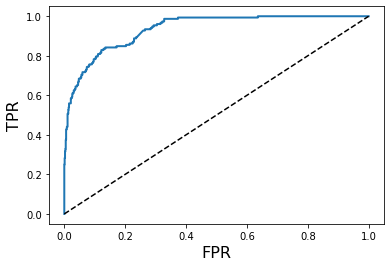

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(Real, Modelo)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('TPR', fontsize=16) 
    
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(Real, Modelo)

0.9350780366788092

Conociendo el grafico podemos notar como  la pendiente de los Verdaderos positivos se mantienen positiva hasta el punto en el que llega cercana a 0,2. Si recordamos de la parte anterior, podemos concluir que al acercarse al punto de equilibrio entre presicion y recall, la pendiente de los Verdaderos positivos decrecera, mientras que los Falsos positivos aumentara. Esto se debe a que la relacion entre los dos es inversa y podemos notar gracias al grafico claramente en que punto del Threshold ocurre esto.